# K-Means Clustering & UMAP Visualization

In [1]:
import sys
import gzip
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MiniBatchKMeans
import umap
import matplotlib.pyplot as plt
import seaborn as sns

src_dir = Path.cwd().parent

# sys.path strictly for importing modules
sys.path.append(str(src_dir))
from utils.data_utils import *

DATA_PATH = src_dir / "data" / "processed"
COHORT_PATH = src_dir / "data" / "processed" / "diabetic_patient_day_table.csv.gz"

In [2]:
all_embeddings = np.load(DATA_PATH / "patient_embeddings.npy")
patient_ids = np.load(DATA_PATH / "patient_ids.npy")

emb_df = pd.DataFrame(all_embeddings, index=patient_ids)
emb_df.index.name = "patient_id"

emb_df.head()

,0
patient_id,
16638841.0,0.365061
13006599.0,0.365025
15057166.0,0.364830
18529984.0,0.364873
19387056.0,0.364791


In [70]:
cohort = load_data(COHORT_PATH)
print(cohort.shape)
cohort.head()

(1372192, 65)


,subject_id,chartdate,50803,50809,50822,50824,50837,50841,50842,50847,...,n_admissions,first_admission_date,last_admission_date,hypertension_flag,ckd_flag,obesity_flag,neuropathy_flag,retinopathy_flag,heart_disease_flag,insulin_flag
0,10000635,2136-04-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2136-06-19 14:24:00,2143-12-23 14:55:00,True,NaN,True,NaN,NaN,NaN,False
1,10000635,2138-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2136-06-19 14:24:00,2143-12-23 14:55:00,True,NaN,True,NaN,NaN,NaN,False
2,10000635,2141-08-15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2136-06-19 14:24:00,2143-12-23 14:55:00,True,NaN,True,NaN,NaN,NaN,False
3,10000635,2142-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2136-06-19 14:24:00,2143-12-23 14:55:00,True,NaN,True,NaN,NaN,NaN,False
4,10000635,2143-06-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,2136-06-19 14:24:00,2143-12-23 14:55:00,True,NaN,True,NaN,NaN,NaN,False


## K-Means Clustering (Mini-Batch)

In [4]:
n_clusters = 5
mbk = MiniBatchKMeans(n_clusters=n_clusters, batch_size=10000, random_state=42)

# Fit and predict
emb_df['cluster'] = mbk.fit_predict(all_embeddings)

print("Cluster counts:")
print(emb_df['cluster'].value_counts())

Cluster counts:
cluster
0    31738
3    10145
2     3124
4      941
Name: count, dtype: int64


In [5]:
all_embeddings.shape

(45948, 1)

In [30]:
# Perform UMAP dimensionality reduction
reducer = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1, 
    n_components=2, 
    random_state=42,
    verbose=True
)

# umap_embeddings = reducer.fit_transform(all_embeddings[:10000])
umap_embeddings = reducer.fit_transform(all_embeddings)

/opt/anaconda3/envs/cph100_final/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(n_jobs=1, random_state=42, verbose=True)
Sat Dec 13 11:17:44 2025 Construct fuzzy simplicial set
Sat Dec 13 11:17:44 2025 Finding Nearest Neighbors
Sat Dec 13 11:17:44 2025 Building RP forest with 16 trees
Sat Dec 13 11:17:44 2025 NN descent for 15 iterations
	 1  /  15
	 2  /  15
	 3  /  15
	 4  /  15
	Stopping threshold met -- exiting after 4 iterations
Sat Dec 13 11:17:45 2025 Finished Nearest Neighbor Search
Sat Dec 13 11:17:45 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat Dec 13 11:18:24 2025 Finished embedding


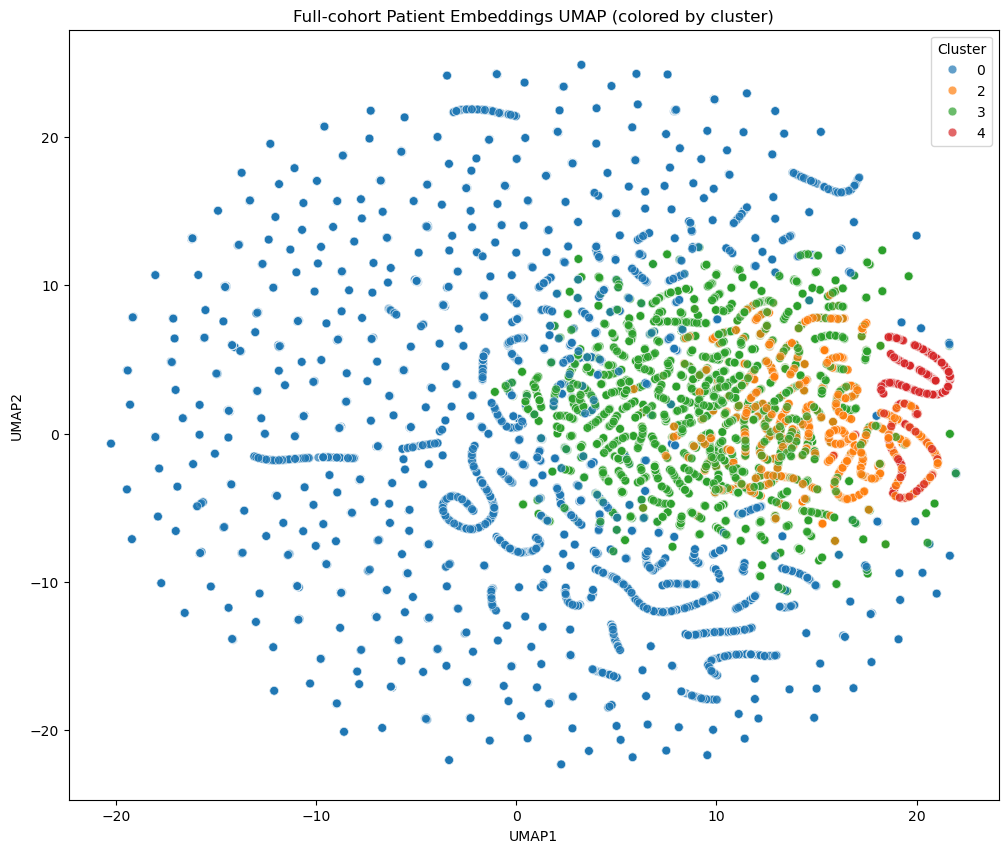

In [97]:
umap_df = pd.DataFrame(
    umap_embeddings, 
    columns=['UMAP1', 'UMAP2'], 
    index=patient_ids
)
umap_df['cluster'] = emb_df['cluster']

plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=umap_df,
    x='UMAP1',
    y='UMAP2',
    hue='cluster',
    palette='tab10',
    s=40,
    alpha=0.7
)
plt.title("Full-cohort Patient Embeddings UMAP (colored by cluster)")
plt.legend(title='Cluster')
plt.savefig("../visualizations/full_cohort_patient_umap_clusters.png", dpi=300)
plt.show()

In [98]:
print(umap_df.columns)
umap_df.index = umap_df.index.rename("subject_id")
umap_df.index = umap_df.index.astype("float32")
umap_df = umap_df.reset_index()
umap_df.head()

Index(['UMAP1', 'UMAP2', 'cluster'], dtype='object')


,subject_id,UMAP1,UMAP2,cluster
0,16638841.0,5.947987,18.438675,0
1,13006599.0,14.449021,-9.632791,0
2,15057166.0,13.848846,-0.824687,2
3,18529984.0,9.933805,-3.972121,3
4,19387056.0,14.065262,5.188116,3


In [99]:
umap_df.dtypes

subject_id    float32
UMAP1         float32
UMAP2         float32
cluster         int32
dtype: object

In [100]:
cohort['subject_id'] = cohort['subject_id'].astype("float32")
cohort.head()

KeyError: 'subject_id'

In [101]:
if "chartdate" in cohort.columns:
    cohort = cohort.drop(columns=["chartdate"])

flag_cols = [
    'hypertension_flag', 'ckd_flag', 'obesity_flag', 'neuropathy_flag',
    'retinopathy_flag', 'heart_disease_flag', 'insulin_flag'
]

static_cols = [
    'subject_id', 'gender', 'age', 'n_admissions',
    'first_admission_date', 'last_admission_date'
] + flag_cols

lab_cols = [c for c in cohort.columns if c not in static_cols]

FLAG_MAP = {
    True: 1, False: 0,
    "True": 1, "False": 0,
    "Y": 1, "N": 0,
    "Yes": 1, "No": 0,
    1: 1, 0: 0
}

for col in flag_cols:
    cohort[col] = (
        cohort[col]
        .map(FLAG_MAP)
        .fillna(0)
        .astype("float32")
    )
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").fillna(0).astype("float32")
    print(col, cohort[col].dropna().unique()[:5])

for col in lab_cols:
    cohort[col] = pd.to_numeric(cohort[col], errors="coerce").astype("float32")

hypertension_flag [1. 0.]
ckd_flag [0. 1.]
obesity_flag [1. 0.]
neuropathy_flag [0. 1.]
retinopathy_flag [0. 1.]
heart_disease_flag [0. 1.]
insulin_flag [0. 1.]


In [102]:
cohort.head()

,50803,50809,50822,50824,50837,50841,50842,50847,50848,50852,...,n_admissions,first_admission_date,last_admission_date,hypertension_flag,ckd_flag,obesity_flag,neuropathy_flag,retinopathy_flag,heart_disease_flag,insulin_flag
subject_id,,,,,,,,,,,,,,,,,,,,,
10000635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2136-06-19 14:24:00,2143-12-23 14:55:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0
10000980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.109091,...,7.0,2188-01-03 17:41:00,2193-08-15 01:01:00,0.0,1.0,1.0,1.0,1.0,1.0,1.0
10001176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2186-11-29 03:56:00,2186-11-29 03:56:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0
10001843.0,NaN,NaN,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2131-11-09 16:05:00,2134-12-05 00:10:00,0.0,1.0,1.0,0.0,0.0,1.0,1.0
10001877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.700000,...,2.0,2149-05-21 15:53:00,2150-11-21 23:02:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [103]:
cohort["first_admission_date"] = pd.to_datetime(cohort["first_admission_date"], errors="coerce")
cohort["last_admission_date"] = pd.to_datetime(cohort["last_admission_date"], errors="coerce")

cohort["gender"] = cohort["gender"].map({"M": 0, "F": 1}).astype("float32")
cohort["age"] = pd.to_numeric(cohort["age"], errors="coerce").astype("float32")
cohort["n_admissions"] = pd.to_numeric(cohort["n_admissions"], errors="coerce").astype("float32")

cohort = cohort.groupby("subject_id").agg({

    # all labs averaged
    **{col: "mean" for col in lab_cols},

    # simple safe keep rules
    "gender": "first",
    "age": "mean",
    "n_admissions": "max",
    "first_admission_date": "min",
    "last_admission_date": "max",
    "hypertension_flag": "max",
    "ckd_flag": "max",
    "obesity_flag": "max",
    "neuropathy_flag": "max",
    "retinopathy_flag": "max",
    "heart_disease_flag": "max",
    "insulin_flag": "max",
})

print(cohort.columns)

cohort.head()

Index(['50803', '50809', '50822', '50824', '50837', '50841', '50842', '50847',
       '50848', '50852', '50854', '50882', '50912', '50931', '50971', '50983',
       '51021', '51022', '51027', '51032', '51034', '51041', '51042', '51048',
       '51052', '51053', '51057', '51058', '51061', '51064', '51065', '51067',
       '51070', '51073', '51076', '51080', '51081', '51082', '51084', '51097',
       '51099', '51100', '51106', '51478', '51790', '51981', '52024', '52546',
       '52569', '52610', '52623', 'gender', 'age', 'n_admissions',
       'first_admission_date', 'last_admission_date', 'hypertension_flag',
       'ckd_flag', 'obesity_flag', 'neuropathy_flag', 'retinopathy_flag',
       'heart_disease_flag', 'insulin_flag'],
      dtype='object')


,50803,50809,50822,50824,50837,50841,50842,50847,50848,50852,...,n_admissions,first_admission_date,last_admission_date,hypertension_flag,ckd_flag,obesity_flag,neuropathy_flag,retinopathy_flag,heart_disease_flag,insulin_flag
subject_id,,,,,,,,,,,,,,,,,,,,,
10000635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2136-06-19 14:24:00,2143-12-23 14:55:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0
10000980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.109091,...,7.0,2188-01-03 17:41:00,2193-08-15 01:01:00,0.0,1.0,1.0,1.0,1.0,1.0,1.0
10001176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,2186-11-29 03:56:00,2186-11-29 03:56:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0
10001843.0,NaN,NaN,3.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,2131-11-09 16:05:00,2134-12-05 00:10:00,0.0,1.0,1.0,0.0,0.0,1.0,1.0
10001877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.700000,...,2.0,2149-05-21 15:53:00,2150-11-21 23:02:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [104]:
clustered_df = cohort.merge(
    umap_df[['subject_id', 'cluster']],
    on='subject_id',
    how='left'
)
clustered_df.head()

,subject_id,50803,50809,50822,50824,50837,50841,50842,50847,50848,...,first_admission_date,last_admission_date,hypertension_flag,ckd_flag,obesity_flag,neuropathy_flag,retinopathy_flag,heart_disease_flag,insulin_flag,cluster
0,10000635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2136-06-19 14:24:00,2143-12-23 14:55:00,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3
1,10000980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2188-01-03 17:41:00,2193-08-15 01:01:00,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3
2,10001176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2186-11-29 03:56:00,2186-11-29 03:56:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0
3,10001843.0,NaN,NaN,3.7,NaN,NaN,NaN,NaN,NaN,NaN,...,2131-11-09 16:05:00,2134-12-05 00:10:00,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3
4,10001877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2149-05-21 15:53:00,2150-11-21 23:02:00,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0


In [105]:
umap_df.head()

,subject_id,UMAP1,UMAP2,cluster
0,16638841.0,5.947987,18.438675,0
1,13006599.0,14.449021,-9.632791,0
2,15057166.0,13.848846,-0.824687,2
3,18529984.0,9.933805,-3.972121,3
4,19387056.0,14.065262,5.188116,3


In [106]:
umap_df.dtypes

subject_id    float32
UMAP1         float32
UMAP2         float32
cluster         int32
dtype: object

In [107]:
plot_df = clustered_df.merge(umap_df[["subject_id", "UMAP1", "UMAP2"]], on="subject_id", how="left")
plot_df.head()

,subject_id,50803,50809,50822,50824,50837,50841,50842,50847,50848,...,hypertension_flag,ckd_flag,obesity_flag,neuropathy_flag,retinopathy_flag,heart_disease_flag,insulin_flag,cluster,UMAP1,UMAP2
0,10000635.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,3,19.193142,-0.370570
1,10000980.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,3,13.497470,1.691845
2,10001176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,-2.213166,-1.643407
3,10001843.0,NaN,NaN,3.7,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,1.0,0.0,0.0,1.0,1.0,3,5.439012,-3.145486
4,10001877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0,16.641520,10.903310


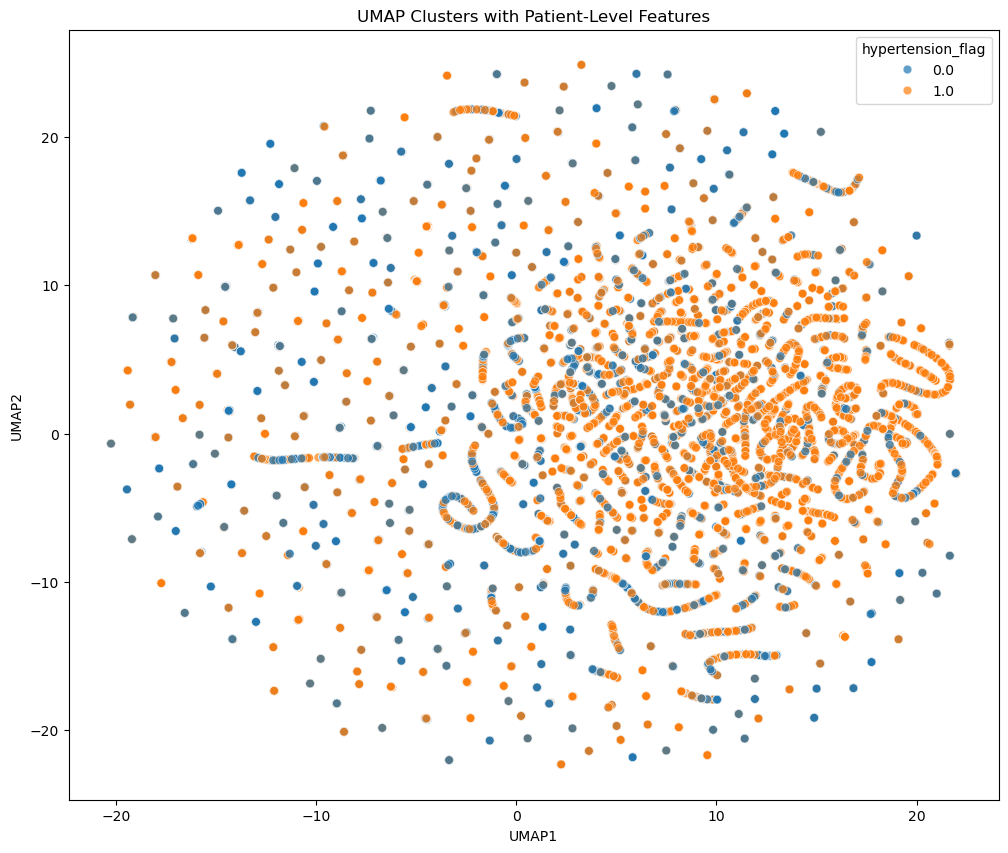

In [108]:
plt.figure(figsize=(12,10))
sns.scatterplot(
    data=plot_df,
    x='UMAP1', y='UMAP2',
    hue='hypertension_flag',
    palette='tab10',
    s=40, alpha=0.7
)
plt.title("UMAP Clusters with Patient-Level Features")
plt.savefig("../visualizations/umap_patient_features_hypertension.png", dpi=300)
plt.show()

In [109]:
cluster_summary = (
    clustered_df
    .groupby("cluster")
    .agg(
        n_patients=("age", "count"),
        mean_age=("age", "mean"),
        mean_admissions=("n_admissions", "mean"),
        insulin_rate=("insulin_flag", "mean"),
        hypertension_rate=("hypertension_flag", "mean"),
        ckd_rate=("ckd_flag", "mean"),
        obesity_rate=("obesity_flag", "mean"),
        neuropathy_rate=("neuropathy_flag", "mean"),
        retinopathy_rate=("retinopathy_flag", "mean"),
    )
)

cluster_summary

,n_patients,mean_age,mean_admissions,insulin_rate,hypertension_rate,ckd_rate,obesity_rate,neuropathy_rate,retinopathy_rate
cluster,,,,,,,,,
0,31738,66.122513,1.959355,0.839813,0.570105,0.266967,0.202218,0.155019,0.066986
2,3124,60.171730,8.532331,0.891485,0.826825,0.450704,0.422535,0.348592,0.192382
3,10145,63.027336,6.461607,0.896895,0.749138,0.434007,0.359487,0.303302,0.153672
4,941,58.188099,11.902231,0.884166,0.871413,0.489904,0.453773,0.408077,0.212540


### p-value test to check statistical differentiation across clusters

In [110]:
from scipy.stats import kruskal

for col in [
    "age", "n_admissions",
    "insulin_flag", "hypertension_flag",
    "ckd_flag", "obesity_flag"
]:
    groups = [
        clustered_df[clustered_df["cluster"] == k][col]
        for k in clustered_df["cluster"].unique()
    ]
    stat, p = kruskal(*groups)
    print(f"{col}: p={p:.2e}")

age: p=1.81e-219
n_admissions: p=0.00e+00
insulin_flag: p=1.31e-52
hypertension_flag: p=0.00e+00
ckd_flag: p=8.66e-300
obesity_flag: p=0.00e+00


### Heatmap for cluster-level comorbidity/flag rates

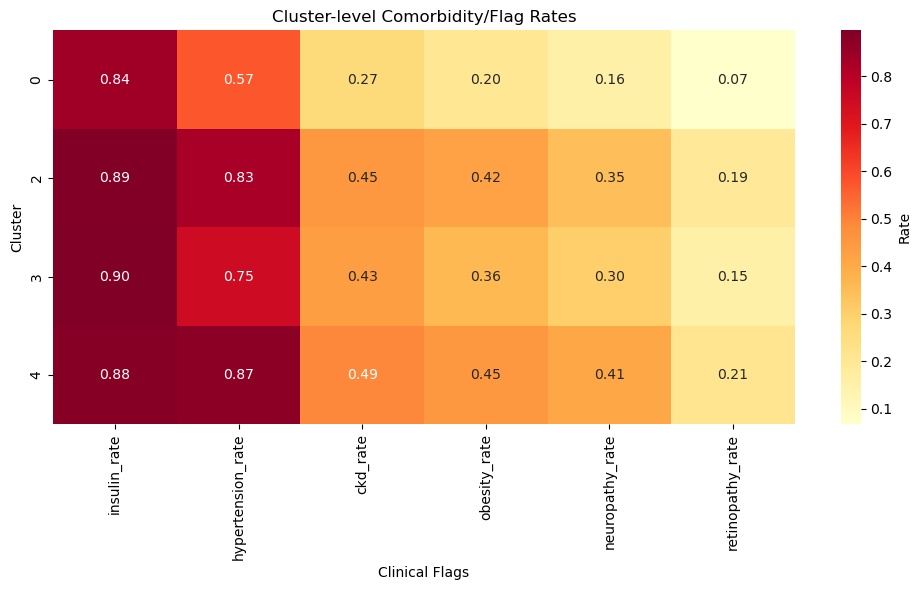

In [112]:
flag_cols = [
    "insulin_rate", "hypertension_rate", "ckd_rate", 
    "obesity_rate", "neuropathy_rate", "retinopathy_rate"
]

heatmap_df = cluster_summary[flag_cols]

plt.figure(figsize=(10, 6))
sns.heatmap(
    heatmap_df, 
    annot=True,          # show values in cells
    fmt=".2f",           # format decimals
    cmap="YlOrRd",       # color map (yellow → red)
    cbar_kws={'label': 'Rate'}  # label colorbar
)
plt.title("Cluster-level Comorbidity/Flag Rates")
plt.ylabel("Cluster")
plt.xlabel("Clinical Flags")
plt.tight_layout()
plt.savefig("../visualizations/cluster_comorbidity_heatmap.png", dpi=300)
plt.show()